# Probabilistic Macrochemical Modeling: Scenario 2 (*changing* cell weights)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

figdims = (5, 3.6)  # figure dimensions in inches

In [2]:
import numpy as np
import pystan
import pickle
import pandas as pd
from scipy import stats
from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['legend.numpoints'] = 1
from matplotlib.transforms import Bbox

from srbsim import SRBGrowthSim

## Generate data (*changing* cell weights)

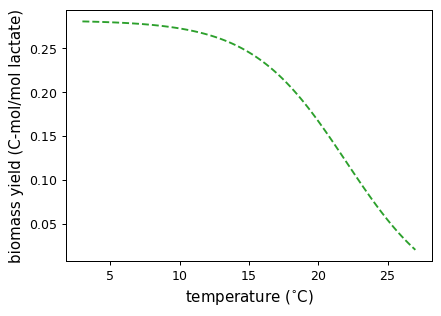

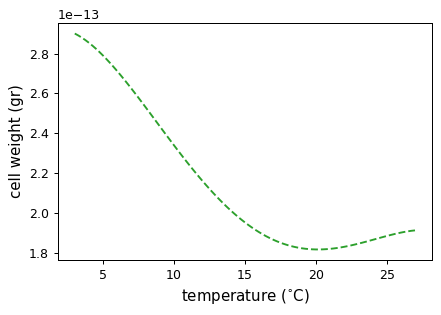

In [3]:
# auxiliary functions for specifying the curves
s = lambda x: 1./(1 + np.exp(-x))  # sigmoid
g = lambda x, e=2: np.exp(-0.5*(np.abs(x)**e))  # gaussian

# generation curves
def growth_rate_function(t, l0):
    return np.maximum(1e-6, 0.04*g((t-19)/10, e=1.6)*s(-1.0*(t-19-6/1.0)))

def biomass_yield_function(t, l0):
    return np.maximum(1e-6, 0.322*s(-(t-22)/3.4) - 0.04)

def cell_weight_function(t, l0):
    p = np.polyfit([0, 10, 20, 22, 25, 30], [1.6, 1.3, 1.0, 1.03, 1.04, 1.04], deg=4)
    return np.polyval(p, t) * 1.8e-13

t = np.linspace(3, 27, 97)

fig = plt.figure(figsize=figdims, dpi=90)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

fig = plt.figure(figsize=figdims, dpi=90)
plt.plot(t, cell_weight_function(t, None), '--', color='tab:green')
plt.ylabel(r'cell weight (gr)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

In [4]:
concentrations_noise = {
     'lactate': 0.15,
     'sulfate': 0.3,
     'acetate': 0.2,
     'bicarbonate': 0.8,
     'sulfide': 0.4}

# initialize the data generator
sim = SRBGrowthSim(biomass_yield_curve=biomass_yield_function,
                   cell_weight_curve=cell_weight_function,
                   concentrations_noise=concentrations_noise,
                   cell_count_noise=2e8)

conditions = [5, 10, 15, 20, 25]  # temperature conditions (in 'C)
n_conditions = len(conditions)
n_replicates = 3

# generate data
np.random.seed(20200601)
gt = []  # ground truth values
delta_conditions = []
for t in conditions:
    for i in range(n_replicates):
        latent, _, deltas = sim.generate(t, initial_cell_count=1e7)
        gt.append({
            'temp': t,
            'initial_biomass': latent[0],  # (C-mol)
            'final_biomass': latent[1],    # (C-mol)
            'lactate_cat': latent[2],      # (mM)
            'lactate_anab': latent[3]})    # (mM)
        deltas['temp'] = t
        delta_conditions.append(deltas)

# arrange data into DataFrames
gt_vals = pd.DataFrame(gt, columns=['temp', 'initial_biomass', 'final_biomass',
                                    'lactate_cat', 'lactate_anab'])
delta_vals = pd.DataFrame(delta_conditions,
                          columns=['temp', 'lactate', 'sulfate', 'acetate',
                                   'bicarbonate', 'sulfide', 'n_cells'])
delta_vals

,temp,lactate,sulfate,acetate,bicarbonate,sulfide,n_cells
0,5,-29.891545,-12.714893,27.015971,25.730172,13.524916,1.981092e+09
1,5,-29.864061,-13.636548,27.211480,28.860091,14.508144,2.216379e+09
2,5,-30.049761,-13.463471,27.215575,28.195255,13.539260,2.151305e+09
3,10,-30.301319,-12.920842,27.693236,28.319127,12.908176,2.804919e+09
4,10,-29.819079,-13.475302,27.332002,27.064108,12.620619,2.307340e+09
5,10,-30.266737,-13.561216,27.095586,28.701566,13.740277,2.512866e+09
6,15,-30.193569,-13.172566,27.015654,25.878538,15.042553,3.150343e+09
7,15,-29.617921,-13.751402,26.914417,26.109168,14.067182,2.918897e+09
8,15,-30.267264,-13.671174,27.629648,28.961052,14.268825,2.740941e+09
9,20,-29.660149,-14.611721,28.259595,30.229001,13.585194,1.889957e+09


## Estimation of biomass yields from *pairings* of compound measurements

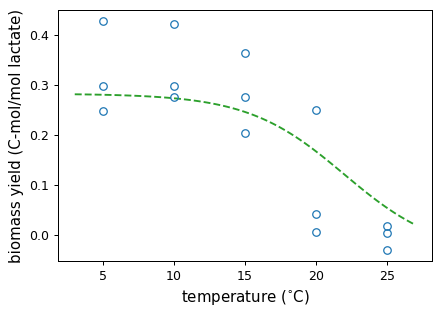

In [5]:
# estimation of biomass yield using lactate and sulfate measurements

lactate_cat = (1/0.5) * delta_vals['sulfate']  # sulfate is consumed at *half* the rate of lactate in the catabolic reaction
lactate_anab = delta_vals['lactate'] - lactate_cat
biomass_produced = (1/-0.35) * lactate_anab
yield_from_sulfate =  biomass_produced / -delta_vals['lactate']

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.plot(delta_vals['temp'], yield_from_sulfate, 'o', fillstyle='none')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

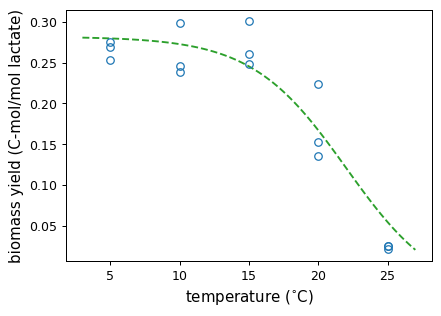

In [6]:
# estimation of biomass yield using lactate and acetate measurements

lactate_cat = -delta_vals['acetate']
lactate_anab = delta_vals['lactate'] - lactate_cat
biomass_produced = (1/-0.35) * lactate_anab
yield_from_acetate =  biomass_produced / -delta_vals['lactate']

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.plot(delta_vals['temp'], yield_from_acetate, 'o', fillstyle='none')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

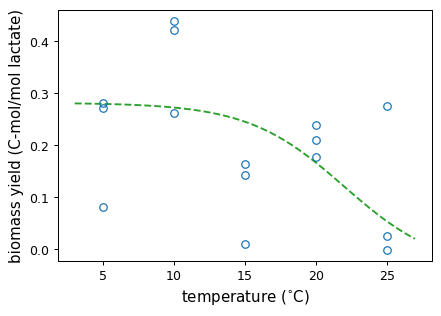

In [7]:
# estimation of biomass yield using lactate and sulfide measurements

lactate_cat = (1/-0.5) * delta_vals['sulfide']
lactate_anab = delta_vals['lactate'] - lactate_cat
biomass_produced = (1/-0.35) * lactate_anab
yield_from_sulfide =  biomass_produced / -delta_vals['lactate']

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.plot(delta_vals['temp'], yield_from_sulfide, 'o', fillstyle='none')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

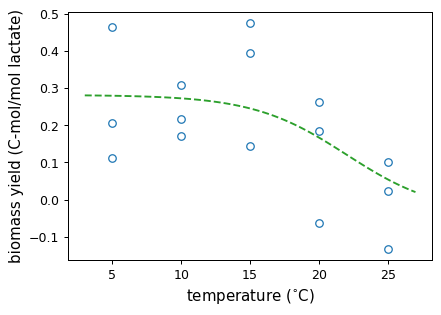

In [8]:
# estimation of biomass yield using lactate and bicarbonate measurements

biomass_produced = (-1/0.30)*(delta_vals['lactate'] + delta_vals['bicarbonate'])
yield_from_bicarbonate =  biomass_produced / -delta_vals['lactate']

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.plot(delta_vals['temp'], yield_from_bicarbonate, 'o', fillstyle='none')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

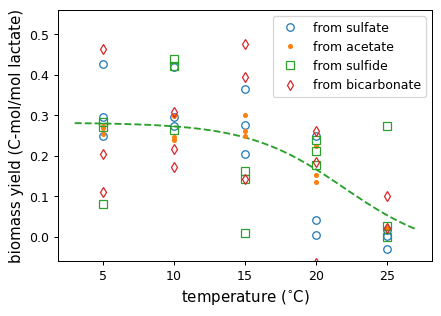

In [9]:
# combined estimates of biomass yields

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')

plt.plot(delta_vals['temp'], yield_from_sulfate, 'o', label='from sulfate', fillstyle='none')
plt.plot(delta_vals['temp'], yield_from_acetate, '.', label='from acetate')
plt.plot(delta_vals['temp'], yield_from_sulfide, 's', label='from sulfide', fillstyle='none')
plt.plot(delta_vals['temp'], yield_from_bicarbonate, 'd', label='from bicarbonate', fillstyle='none')

plt.ylim([-0.06, 0.56])
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.legend()
plt.tight_layout()

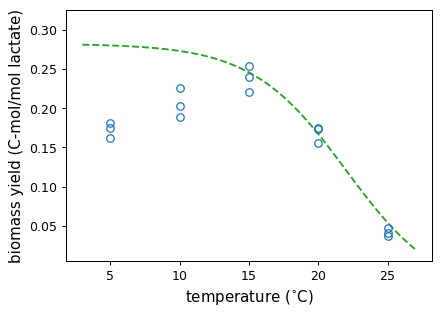

In [10]:
# estimation of biomass yield using lactate measurements and cell counts

biomass_produced = delta_vals['n_cells']*(1.8e-13/24.62)
yield_from_ncells =  biomass_produced*(1e3/sim.volume) / -delta_vals['lactate']

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.plot(delta_vals['temp'], yield_from_ncells, 'o', fillstyle='none')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.ylim(0.005, 0.325)
plt.tight_layout()

---

## *Baseline* Probabilistic model (with *constant* cell weight)
... which understandably infers poorly!

In [11]:
model_name = 'chemical_model_2a_constCellWeight'
model_code = """
    data {
        int<lower=0> M;         # number of conditions
        int<lower=0> R;         # number of replicates per condition
        real<lower=0> vol;      # volume to convert concentrations to millimoles (liters)
        
        # measured change in concentration of the different compounds (mM)
        vector<upper=0>[R] delta_lactate_obs[M];    
        vector<upper=0>[R] delta_sulfate_obs[M];
        vector<lower=0>[R] delta_acetate_obs[M];
        vector<lower=0>[R] delta_bicarbonate_obs[M];
        vector<lower=0>[R] delta_sulfide_obs[M];

        # difference in cell counts
        vector<lower=0>[R] delta_ncells_obs[M];
    }

    parameters {
        # key hyperparameters for the catabolic vs anabolic split
        # change in lactate concentration due to catabolic and anabolic reactions (mM)
        real<upper=-1e-3> delta_lactate_cat[M];
        real<upper=-1e-3> delta_lactate_anab[M];
        
        # hyperparameters for standard deviation of experimental
        # measurements of concentration of the compounds and cell counts
        real<lower=0> s_lactate;
        real<lower=0> s_sulfate;
        real<lower=0> s_acetate;
        real<lower=0> s_bicarbonate;
        real<lower=0> s_sulfide;
        real<lower=0> s_cell_count;

        real<lower=1e-14, upper=2e-12> cell_weight;         # cell mean weight hyperparameter
    }

    transformed parameters {
        real<lower=0> delta_biomass[M];             # change in biomass (millimoles)
        real<lower=0> biomass_yield[M];             # C-moles of biomass produced per mol of e- donor (Y_DX)
        real<lower=0> cat_scaling[M];               # scaling of cat reaction in macrochem eq

        for (m in 1:M) {
            delta_biomass[m] = -(1/0.35) * delta_lactate_anab[m] * vol;
            biomass_yield[m] = -delta_biomass[m] \
                                / ((delta_lactate_cat[m] + delta_lactate_anab[m]) * vol);
            cat_scaling[m] = 0.35 * delta_lactate_cat[m] / delta_lactate_anab[m];
        }
    }

    model {
        # priors on standard deviation of experimental measurements
        # (common to all conditions and replicates)
        real c;
        c = 1/0.1;
        s_lactate ~ exponential(c);
        s_sulfate ~ exponential(c);
        s_acetate ~ exponential(c);
        s_sulfide ~ exponential(c);
        s_bicarbonate ~ exponential(c);

        # cell priors
        s_cell_count ~ exponential(1/1e8);
        cell_weight ~ lognormal(-29.346 + 0.09, 0.3);      # log(1.8e-13) = -29.346,
                                                           # mode is at (mu - sigma^2)

        for (m in 1:M) {
            # priors on key chemical concentrations
            delta_lactate_cat[m] ~ normal(-28, 0.5);   #-lognormal(3.33, 0.3);  # exp(3.33) ~= 28
            delta_lactate_anab[m] ~ normal(-2, 0.5);   #-lognormal(0.7, 0.3);    # exp(0.7) ~= 2

            # finally related key parameters to concentration measurements
            delta_lactate_obs[m] ~ normal(delta_lactate_cat[m] + delta_lactate_anab[m], s_lactate*sqrt(2));
            delta_sulfate_obs[m] ~ normal( 0.5*delta_lactate_cat[m], s_sulfate*sqrt(2));
            delta_acetate_obs[m] ~ normal(-1.0*delta_lactate_cat[m], s_acetate*sqrt(2));
            delta_sulfide_obs[m] ~ normal(-0.5*delta_lactate_cat[m], s_sulfide*sqrt(2));
            delta_bicarbonate_obs[m] ~ normal(-delta_lactate_cat[m]-(0.05/0.35)*delta_lactate_anab[m], s_bicarbonate*sqrt(2));

            # relate biomass estimates to observed cell growth
            delta_ncells_obs[m] ~ normal(delta_biomass[m] * 1e-3 * 24.62/cell_weight, s_cell_count);
        }
    }
"""

fn = model_name + '.stan.pkl'
try:
    stan_model = pickle.load(open(fn, 'rb'))
    no_model_file = False
except Exception:
    no_model_file = True

if no_model_file or stan_model.model_code != model_code:
    print("(Re)compiling Stan model...")
    stan_model = pystan.StanModel(model_code=model_code,
                                  model_name=model_name)
    with open(fn, 'wb') as fh:
        pickle.dump(stan_model, fh)
    print("Cached model for reuse.")
else:
    print("Using cached model.")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL chemical_model_2a_constCellWeight_64248431a50bf4ab9cdffd1d7a3f5e72 NOW.


(Re)compiling Stan model...
Cached model for reuse.


In [12]:
model_fit_alldata = stan_model.sampling(
    data={'M': n_conditions,
          'R': n_replicates,
          'vol': sim.volume,
          'delta_lactate_obs': np.array(delta_vals['lactate']).reshape((n_conditions, n_replicates)),
          'delta_sulfate_obs': np.array(delta_vals['sulfate']).reshape((n_conditions, n_replicates)),
          'delta_acetate_obs': np.array(delta_vals['acetate']).reshape((n_conditions, n_replicates)),
          'delta_sulfide_obs': np.array(delta_vals['sulfide']).reshape((n_conditions, n_replicates)),
          'delta_bicarbonate_obs': np.array(delta_vals['bicarbonate']).reshape((n_conditions, n_replicates)),
          'delta_ncells_obs': np.array(delta_vals['n_cells']).reshape((n_conditions, n_replicates))},
    iter=2000, warmup=1000, chains=4,
    n_jobs=4, seed=20200601)

np.set_printoptions(precision=3, linewidth=90, suppress=True)
print(model_fit_alldata)

Inference for Stan model: chemical_model_2a_constCellWeight_64248431a50bf4ab9cdffd1d7a3f5e72.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                         mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lactate_cat[1]   -27.36  2.4e-3    0.14  -27.67  -27.45  -27.36  -27.27  -27.11   3267    1.0
delta_lactate_cat[2]   -27.41  2.0e-3    0.12  -27.66  -27.49   -27.4  -27.32  -27.17   3791    1.0
delta_lactate_cat[3]   -27.23  1.9e-3    0.12  -27.47  -27.31  -27.22  -27.14   -27.0   4103    1.0
delta_lactate_cat[4]   -28.27  2.0e-3    0.12  -28.51  -28.35  -28.27  -28.19  -28.02   3943    1.0
delta_lactate_cat[5]   -29.36  1.9e-3    0.13   -29.6  -29.44  -29.36  -29.28  -29.11   4232    1.0
delta_lactate_anab[1]   -2.22  3.0e-3    0.14   -2.51   -2.32   -2.22   -2.12   -1.95   2344    1.0
delta_lactate_anab[2]   -2.57  2.9e-3    0.14   -2.85   -2.67   -2.58   -2.48   -2.29   

In [13]:
delta_vals.groupby('temp').mean()

,lactate,sulfate,acetate,bicarbonate,sulfide,n_cells
temp,,,,,,
5,-29.935122,-13.271637,27.147675,27.595173,13.857440,2.116259e+09
10,-30.129045,-13.319120,27.373608,28.028267,13.089691,2.541709e+09
15,-30.026252,-13.531714,27.186573,26.982919,14.459520,2.936727e+09
20,-30.123832,-14.535723,28.319897,28.959021,13.958407,2.075647e+09
25,-29.777712,-14.903975,29.533317,29.804716,14.366011,5.116636e+08


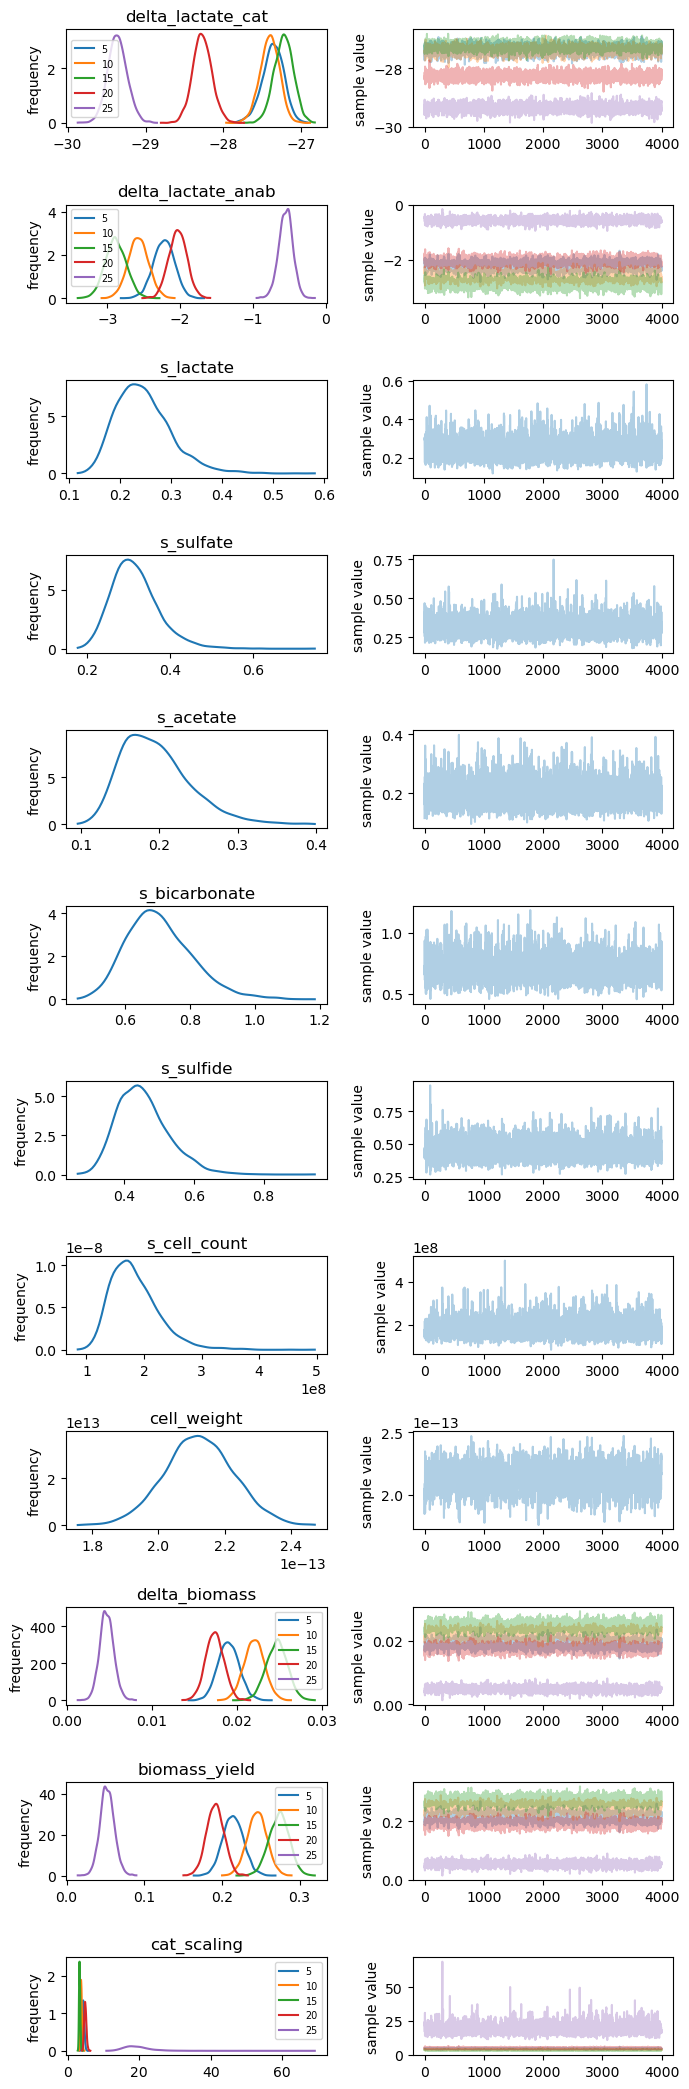

In [14]:
fig = model_fit_alldata.plot()
fig.set_size_inches(7, 21)
fig.set_dpi(100)
for i, a in enumerate(fig.axes):
    if i % 2 == 0 and len(a.get_lines()) > 1:
        a.legend(conditions, fontsize='x-small')
fig.tight_layout()
trim_bbox_in_inches = Bbox(np.array([[0, 0], [3.498, 21]]))

[0.215 0.245 0.274 0.192 0.052]


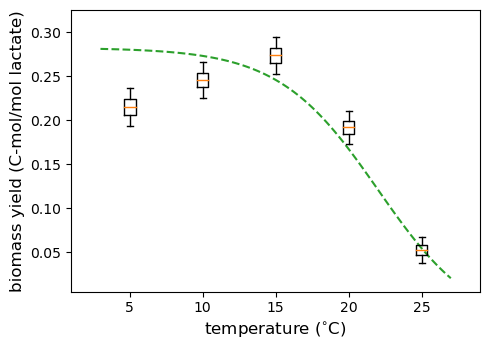

In [15]:
biomass_yield_samples = model_fit_alldata.extract('biomass_yield', permuted=True)['biomass_yield']
print(np.mean(biomass_yield_samples, axis=0))

plt.figure(figsize=figdims, dpi=100)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.boxplot(biomass_yield_samples, positions=conditions,
            widths=0.8, sym='', whis=[5, 95])
plt.xlim(np.min(conditions)-4, np.max(conditions)+4)
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.ylim(0.005, 0.325)
plt.tight_layout()

In [16]:
posterior_means = dict(zip(
    model_fit_alldata.flatnames,
    model_fit_alldata.get_posterior_mean().mean(axis=1)))

print('concentrations_noise =', {k:f'{v:.3f}' for k, v in concentrations_noise.items()})
print('estimated conc noise =', {k[2:]:(f'{v:.3g}' if 'cell_count' in k  else f'{v:.3f}') for k, v in posterior_means.items() if k.startswith('s_')})

concentrations_noise = {'lactate': '0.150', 'sulfate': '0.300', 'acetate': '0.200', 'bicarbonate': '0.800', 'sulfide': '0.400'}
estimated conc noise = {'lactate': '0.246', 'sulfate': '0.316', 'acetate': '0.196', 'bicarbonate': '0.707', 'sulfide': '0.454', 'cell_count': '1.84e+08'}


----

## Probabilistic model (with cell counts and *cell weight per condition*)

In [17]:
model_name = 'chemical_model_2b_cellWeightPerCond'
model_code = """
    data {
        int<lower=0> M;         # number of conditions
        int<lower=0> R;         # number of replicates per condition
        real<lower=0> vol;      # volume to convert concentrations to millimoles (liters)
        
        # measured change in concentration of the different compounds (mM)
        vector<upper=0>[R] delta_lactate_obs[M];    
        vector<upper=0>[R] delta_sulfate_obs[M];
        vector<lower=0>[R] delta_acetate_obs[M];
        vector<lower=0>[R] delta_bicarbonate_obs[M];
        vector<lower=0>[R] delta_sulfide_obs[M];

        # difference in cell counts
        vector<lower=0>[R] delta_ncells_obs[M];
    }

    parameters {
        # key hyperparameters for the catabolic vs anabolic split
        # change in lactate concentration due to catabolic and anabolic reactions (mM)
        real<upper=-1e-3> delta_lactate_cat[M];
        real<upper=-1e-3> delta_lactate_anab[M];
        
        # hyperparameters for standard deviation of experimental
        # measurements of concentration of the compounds and cell counts
        real<lower=0> s_lactate;
        real<lower=0> s_sulfate;
        real<lower=0> s_acetate;
        real<lower=0> s_bicarbonate;
        real<lower=0> s_sulfide;
        real<lower=0> s_cell_count;

        real<lower=1e-14, upper=2e-12> cell_weight[M];         # cell mean weight hyperparameter
    }

    transformed parameters {
        real<lower=0> delta_biomass[M];             # change in biomass (millimoles)
        real<lower=0> biomass_yield[M];             # C-moles of biomass produced per mol of e- donor (Y_DX)
        real<lower=0> cat_scaling[M];               # scaling of cat reaction in macrochem eq

        for (m in 1:M) {
            delta_biomass[m] = -(1/0.35) * delta_lactate_anab[m] * vol;
            biomass_yield[m] = -delta_biomass[m] \
                                / ((delta_lactate_cat[m] + delta_lactate_anab[m]) * vol);
            cat_scaling[m] = 0.35 * delta_lactate_cat[m] / delta_lactate_anab[m];
        }
    }

    model {
        # priors on standard deviation of experimental measurements
        # (common to all conditions and replicates)
        real c;
        c = 1/0.1;
        s_lactate ~ exponential(c);
        s_sulfate ~ exponential(c);
        s_acetate ~ exponential(c);
        s_sulfide ~ exponential(c);
        s_bicarbonate ~ exponential(c);

        # cell priors
        s_cell_count ~ exponential(1/1e8);

        for (m in 1:M) {
            cell_weight[m] ~ lognormal(-29.346 + 0.09, 0.3);   # log(1.8e-13) = -29.346,
                                                               # mode is at (mu - sigma^2)

            # priors on key chemical concentrations
            delta_lactate_cat[m] ~ normal(-28, 0.5);   #-lognormal(3.33, 0.3);  # exp(3.33) ~= 28
            delta_lactate_anab[m] ~ normal(-2, 0.5);   #-lognormal(0.7, 0.3);    # exp(0.7) ~= 2

            # finally related key parameters to concentration measurements
            delta_lactate_obs[m] ~ normal(delta_lactate_cat[m] + delta_lactate_anab[m], s_lactate*sqrt(2));
            delta_sulfate_obs[m] ~ normal( 0.5*delta_lactate_cat[m], s_sulfate*sqrt(2));
            delta_acetate_obs[m] ~ normal(-1.0*delta_lactate_cat[m], s_acetate*sqrt(2));
            delta_sulfide_obs[m] ~ normal(-0.5*delta_lactate_cat[m], s_sulfide*sqrt(2));
            delta_bicarbonate_obs[m] ~ normal(-delta_lactate_cat[m]-(0.05/0.35)*delta_lactate_anab[m], s_bicarbonate*sqrt(2));

            # relate biomass estimates to observed cell growth
            delta_ncells_obs[m] ~ normal(delta_biomass[m] * 1e-3 * 24.62/cell_weight[m], s_cell_count);
        }
    }
"""

fn = model_name + '.stan.pkl'
try:
    stan_model = pickle.load(open(fn, 'rb'))
    no_model_file = False
except Exception:
    no_model_file = True

if no_model_file or stan_model.model_code != model_code:
    print("(Re)compiling Stan model...")
    stan_model = pystan.StanModel(model_code=model_code,
                                  model_name=model_name)
    with open(fn, 'wb') as fh:
        pickle.dump(stan_model, fh)
    print("Cached model for reuse.")
else:
    print("Using cached model.")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL chemical_model_2b_cellWeightPerCond_92cd7698f4dda6f3894f9666592dd108 NOW.


(Re)compiling Stan model...
Cached model for reuse.


In [18]:
model_fit_alldata = stan_model.sampling(
    data={'M': n_conditions,
          'R': n_replicates,
          'vol': sim.volume,
          'delta_lactate_obs': np.array(delta_vals['lactate']).reshape((n_conditions, n_replicates)),
          'delta_sulfate_obs': np.array(delta_vals['sulfate']).reshape((n_conditions, n_replicates)),
          'delta_acetate_obs': np.array(delta_vals['acetate']).reshape((n_conditions, n_replicates)),
          'delta_sulfide_obs': np.array(delta_vals['sulfide']).reshape((n_conditions, n_replicates)),
          'delta_bicarbonate_obs': np.array(delta_vals['bicarbonate']).reshape((n_conditions, n_replicates)),
          'delta_ncells_obs': np.array(delta_vals['n_cells']).reshape((n_conditions, n_replicates))},
    iter=2000, warmup=1000, chains=4,
    n_jobs=4, seed=20200601)

np.set_printoptions(precision=3, linewidth=90, suppress=True)
print(model_fit_alldata)

Inference for Stan model: chemical_model_2b_cellWeightPerCond_92cd7698f4dda6f3894f9666592dd108.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                         mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lactate_cat[1]   -27.25  2.3e-3    0.14  -27.54  -27.34  -27.25  -27.16  -27.01   3401    1.0
delta_lactate_cat[2]   -27.38  2.3e-3    0.13  -27.65  -27.48  -27.38  -27.29  -27.12   3551    1.0
delta_lactate_cat[3]   -27.31  2.5e-3    0.14  -27.61   -27.4  -27.31  -27.22  -27.06   2983    1.0
delta_lactate_cat[4]   -28.34  2.2e-3    0.13   -28.6  -28.42  -28.34  -28.26  -28.09   3189    1.0
delta_lactate_cat[5]   -29.35  2.1e-3    0.13  -29.58  -29.44  -29.35  -29.26  -29.06   3881    1.0
delta_lactate_anab[1]   -2.57  4.3e-3    0.21   -2.96   -2.71   -2.57   -2.44   -2.15   2276    1.0
delta_lactate_anab[2]   -2.65  4.2e-3    0.21   -3.06   -2.79   -2.65   -2.51   -2.23 

In [19]:
delta_vals.groupby('temp').mean()

,lactate,sulfate,acetate,bicarbonate,sulfide,n_cells
temp,,,,,,
5,-29.935122,-13.271637,27.147675,27.595173,13.857440,2.116259e+09
10,-30.129045,-13.319120,27.373608,28.028267,13.089691,2.541709e+09
15,-30.026252,-13.531714,27.186573,26.982919,14.459520,2.936727e+09
20,-30.123832,-14.535723,28.319897,28.959021,13.958407,2.075647e+09
25,-29.777712,-14.903975,29.533317,29.804716,14.366011,5.116636e+08


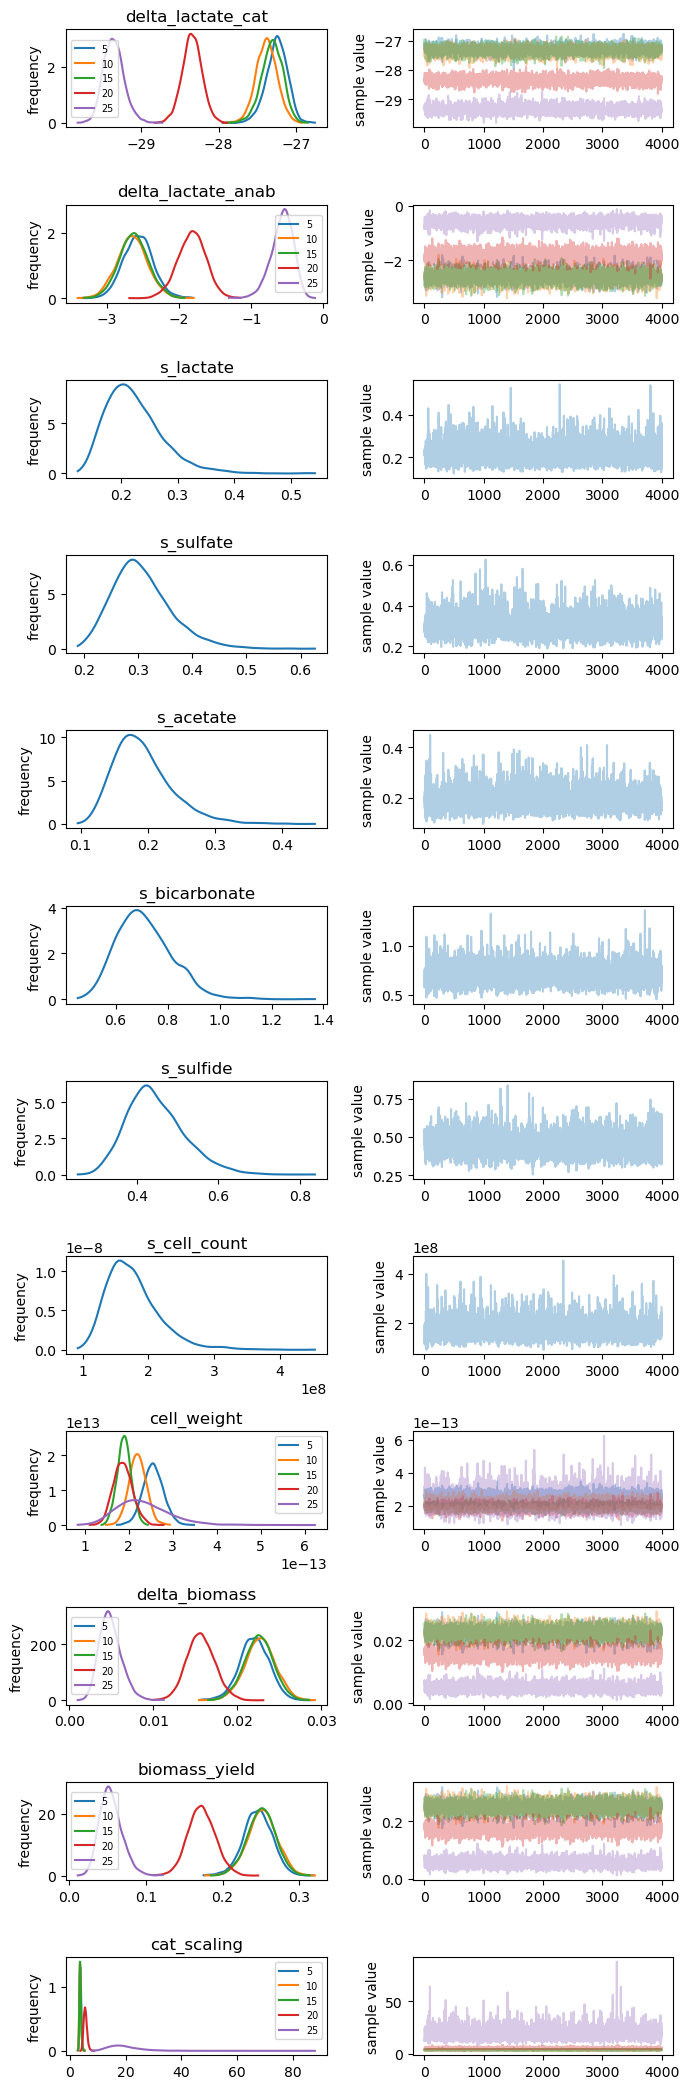

In [20]:
fig = model_fit_alldata.plot()
fig.set_size_inches(7, 21)
fig.set_dpi(100)
for i, a in enumerate(fig.axes):
    if i % 2 == 0 and len(a.get_lines()) > 1:
        a.legend(conditions, fontsize='x-small')
fig.tight_layout()
trim_bbox_in_inches = Bbox(np.array([[0, 0], [3.498, 21]]))

[0.246 0.252 0.251 0.173 0.055]


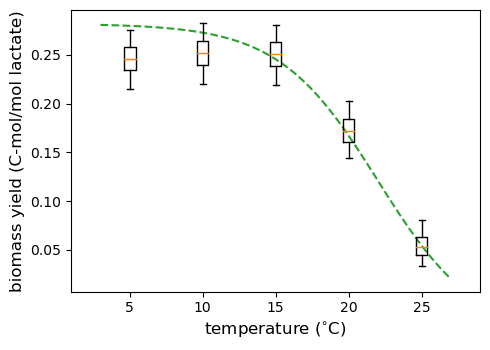

In [21]:
biomass_yield_samples = model_fit_alldata.extract('biomass_yield', permuted=True)['biomass_yield']
print(np.mean(biomass_yield_samples, axis=0))

plt.figure(figsize=figdims, dpi=100)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.boxplot(biomass_yield_samples, positions=conditions,
            widths=0.8, sym='', whis=[5, 95])
plt.xlim(np.min(conditions)-4, np.max(conditions)+4)
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

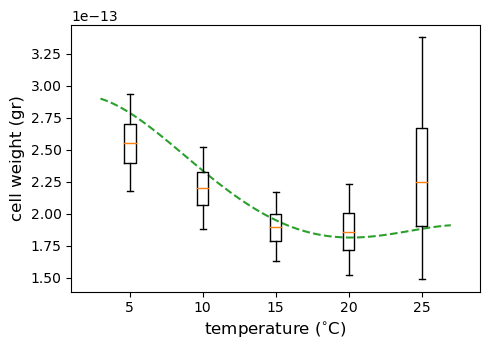

In [22]:
cell_weight_samples = model_fit_alldata.extract('cell_weight', permuted=True)['cell_weight']

plt.figure(figsize=figdims, dpi=100)
t = np.linspace(3, 27, 97)
plt.plot(t, cell_weight_function(t, None), '--', color='tab:green')
plt.boxplot(cell_weight_samples, positions=conditions,
            widths=0.8, sym='', whis=[5, 95])
plt.xlim(np.min(conditions)-4, np.max(conditions)+4)
plt.ylabel(r'cell weight (gr)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

In [23]:
posterior_means = dict(zip(
    model_fit_alldata.flatnames,
    model_fit_alldata.get_posterior_mean().mean(axis=1)))

print('concentrations_noise =', {k:f'{v:.3f}' for k, v in concentrations_noise.items()})
print('estimated conc noise =', {k[2:]:(f'{v:.3g}' if 'cell_count' in k  else f'{v:.3f}') for k, v in posterior_means.items() if k.startswith('s_')})

concentrations_noise = {'lactate': '0.150', 'sulfate': '0.300', 'acetate': '0.200', 'bicarbonate': '0.800', 'sulfide': '0.400'}
estimated conc noise = {'lactate': '0.223', 'sulfate': '0.307', 'acetate': '0.193', 'bicarbonate': '0.712', 'sulfide': '0.447', 'cell_count': '1.76e+08'}
